# Imputacion de Datos Faltantes para la Precipitacion del Meta mediante modelación XGBOOST

Este Jupyter Notebook se enfoca en el desarrolo metodologico del trabajo de grado de los estudiantes Ronaldo Hernandez Mejia y Hector Freddy Velasco, en el cual se enfoca en la imputaciopn de datos faltnates para la variable de precipitacion en el departamento del Meta, Colombia. Con una gran volumen de datos de la informacion diaria de la precipitacion desde 1980 hasta el 2016, seleccionando un total de 56 Estaciones meteorologias del IDEAM.

La región del Meta es muy importante en este país por la diversidad del clima y su efecto sobre la agricultura y otros sectores económicos. La variabilidad de las precipitaciones juega un papel importante en el análisis del clima y la toma de decisiones relacionadas con  la gestión del agua y el clima. 

El objetivo principal es desarrolar un modelo basado en el algotimo K-Nearest Neighbors(KNN) para imputar los datos faltantes de precipitacion, utilizando un conjunto de datos que contiene mas de 700.000 observaciones. 

Dada la gran cantidad de datos se ha implementado una version que utiliza los cores del procesador para ejecutar el modelo en paralelo optimizando asi el tiempo de ejecucion, mejorando la eficiencia computacional y acelerar el proceso, tambien por este motivo el desarrolo en python tiene tiempos de respuesta cortos en el manejo de datos.



### instalacion de librerias

In [1]:
import subprocess
import sys
import importlib

def install_and_import(package):
    try:
        importlib.import_module(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    finally:
        globals()[package] = importlib.import_module(package)


In [3]:
packages = ['pandas', 'IPython', 'pandasgui', 'numpy', 'matplotlib','joblib','sklearn']


for package in packages:
    install_and_import(package)


En caso de que no funcione instalacion manual:

In [4]:
import os
#observar donde estoy en ruta 
os.getcwd()

'c:\\Users\\vhect\\Documents\\semestre 9\\trabajo de grado\\proyecto_prec_vsdcode\\Proyecto_mod_precipitacion\\Codigos de Python'

ruta ronaldo 

In [5]:
# import os
# current_path = os.getcwd()
# print(f"Ruta actual del directorio de trabajo: {current_path}")
# new_path = "F:\\TESIS\\Proyecto_mod_precipitacion"
# os.chdir(new_path)
# new_current_path = os.getcwd()
# print(f"Nueva ruta del directorio de trabajo: {new_current_path}")

ruta hector 


In [6]:
import os
current_path = os.getcwd()
print(f"Ruta actual del directorio de trabajo: {current_path}")
new_path = "c:\\Users\\vhect\\Documents\\semestre 10\\TESIS\\Proyecto_mod_precipitacion"
os.chdir(new_path)
new_current_path = os.getcwd()
print(f"Nueva ruta del directorio de trabajo: {new_current_path}")

Ruta actual del directorio de trabajo: c:\Users\vhect\Documents\semestre 9\trabajo de grado\proyecto_prec_vsdcode\Proyecto_mod_precipitacion\Codigos de Python
Nueva ruta del directorio de trabajo: c:\Users\vhect\Documents\semestre 10\TESIS\Proyecto_mod_precipitacion


### Lectura de datos

In [7]:
import pandas as pd

In [8]:
data = pd.read_csv("Datos/datos_seleccionados_para_modelo_coordenadas.txt",sep=";")
data.head()

,Date,prec,ID,LAT,LON
0,1983-06-09,6.8,32010010,2.562833,-74.103083
1,1983-06-10,17.8,32010010,2.562833,-74.103083
2,1983-06-11,0.0,32010010,2.562833,-74.103083
3,1983-06-12,0.5,32010010,2.562833,-74.103083
4,1983-06-13,6.9,32010010,2.562833,-74.103083


In [9]:
# Asegurarte de que 'Date' es una columna datetime
data['Date'] = pd.to_datetime(data['Date'])

# Crear nuevas columnas para el año, mes y día
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

# Crear un nuevo dataframe con las columnas deseadas
data = data[['ID', 'Year', 'Month', 'Day', 'prec', 'LAT', 'LON']].copy()

## Analisis exploratorio

count    592124.000000
mean          8.915141
std          17.865258
min           0.000000
25%           0.000000
50%           0.000000
75%          10.000000
max         438.800000
Name: prec, dtype: float64


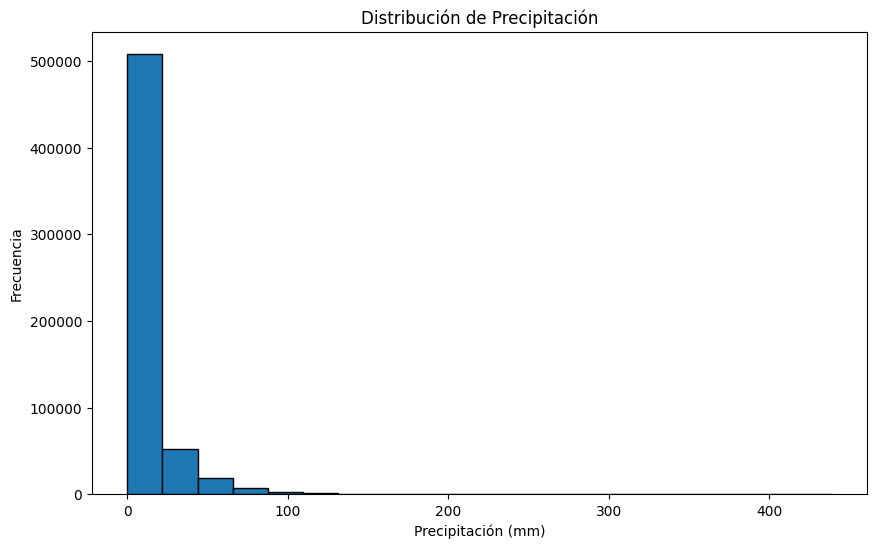

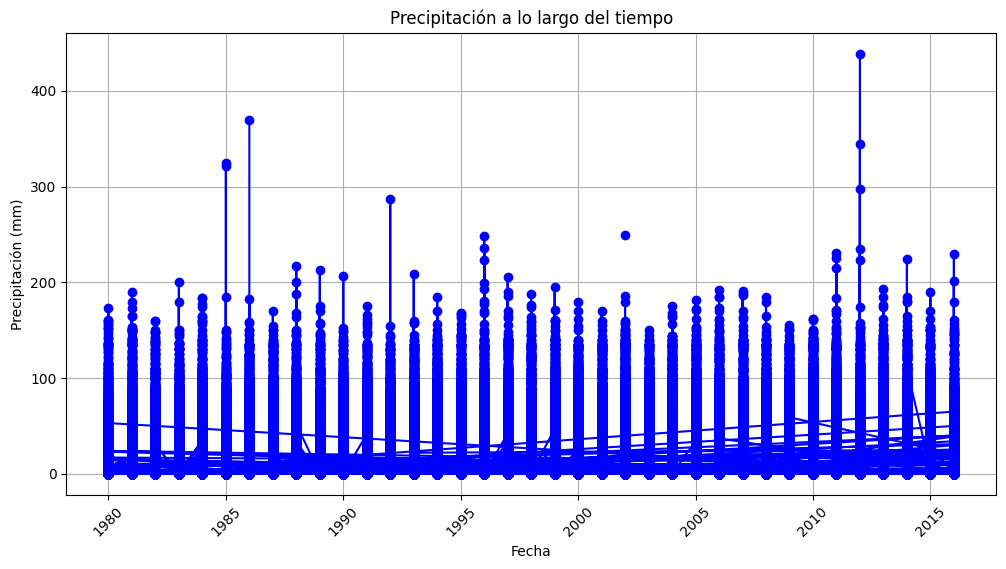

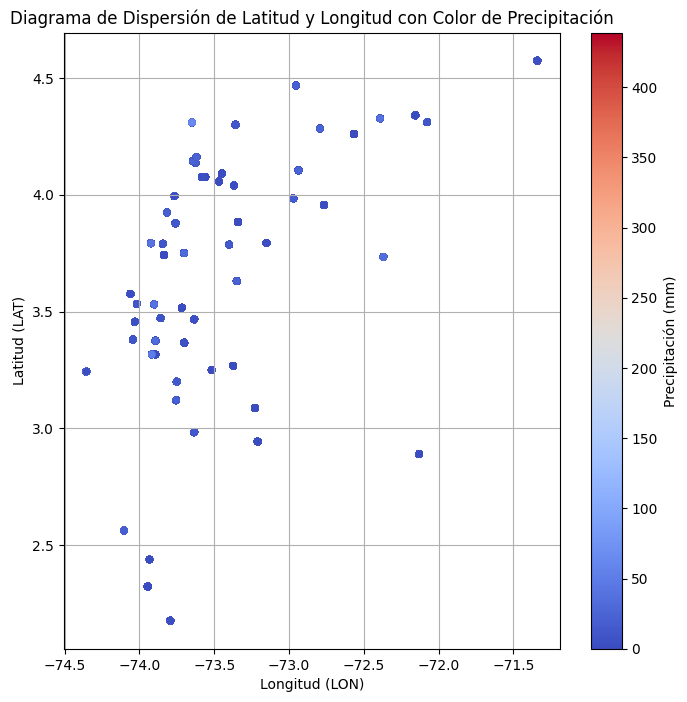

In [10]:
import pandas as pd
import matplotlib.pyplot as plt


# Resumen estadístico de la columna de precipitación
print(data['prec'].describe())

# Histograma de la precipitación
plt.figure(figsize=(10, 6))
plt.hist(data['prec'], bins=20, edgecolor='k')
plt.title('Distribución de Precipitación')
plt.xlabel('Precipitación (mm)')
plt.ylabel('Frecuencia')
plt.show()

# Gráfico de línea de la precipitación a lo largo del tiempo
plt.figure(figsize=(12, 6))
plt.plot(data['Year'], data['prec'], marker='o', linestyle='-', color='b')
plt.title('Precipitación a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Precipitación (mm)')
plt.xticks(rotation=45)  # Para mostrar las fechas de manera legible
plt.grid()
plt.show()

# Diagrama de dispersión de latitud y longitud
plt.figure(figsize=(8, 8))
plt.scatter(data['LON'], data['LAT'], c=data['prec'], cmap='coolwarm', s=20)
plt.title('Diagrama de Dispersión de Latitud y Longitud con Color de Precipitación')
plt.xlabel('Longitud (LON)')
plt.ylabel('Latitud (LAT)')
plt.colorbar(label='Precipitación (mm)')
plt.grid()
plt.show()


## Correlación entre variables

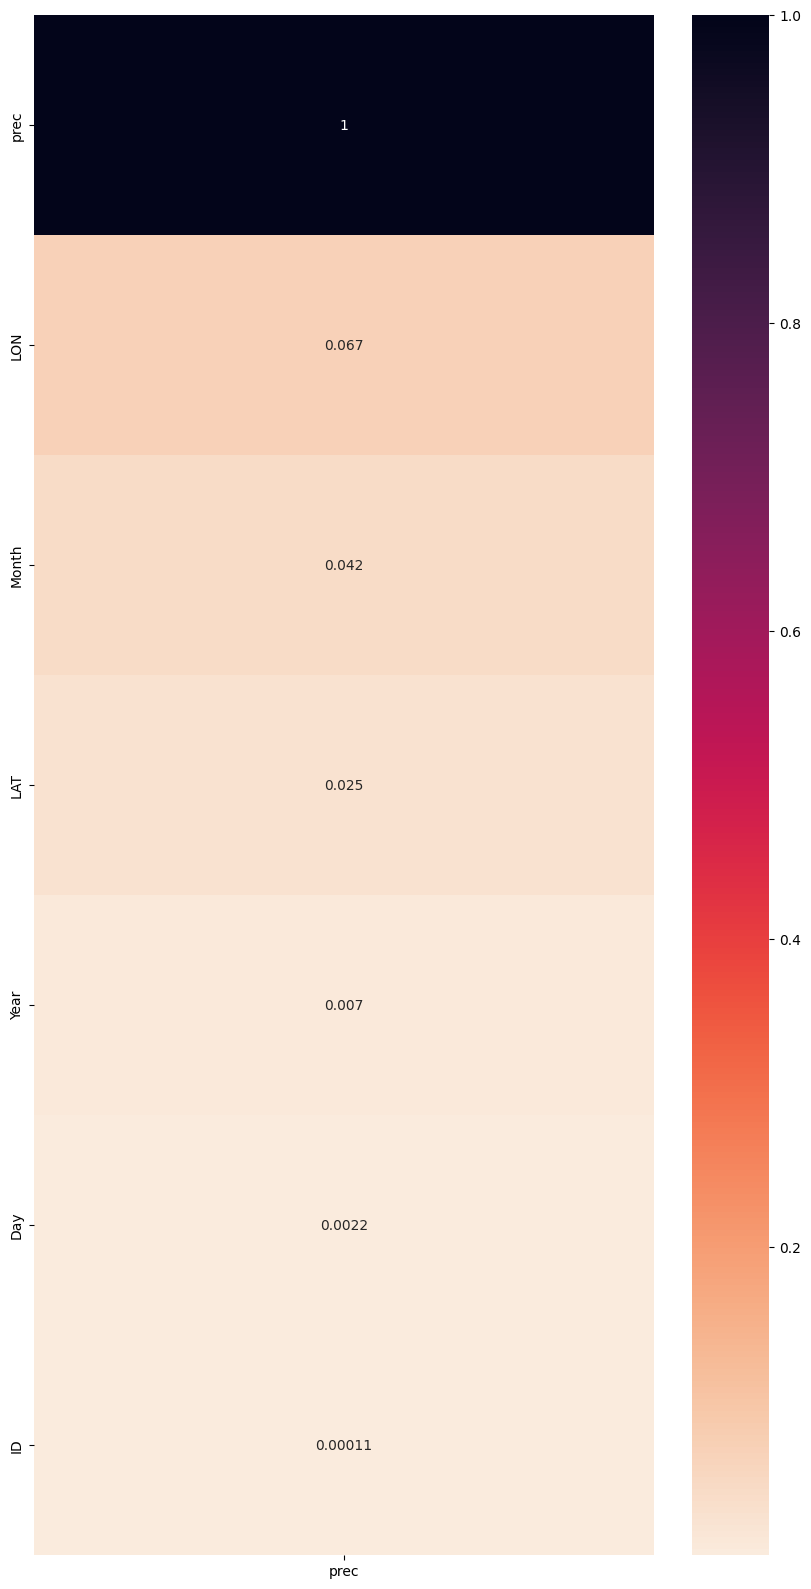

In [11]:
import seaborn as sns
plt.figure(figsize=(10,20))
sns.heatmap(abs(data.corr()[['prec']]).sort_values(by='prec',ascending=False), annot=True, cmap=sns.cm.rocket_r)
plt.show()

Estructura de los datos

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656436 entries, 0 to 656435
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      656436 non-null  int64  
 1   Year    656436 non-null  int32  
 2   Month   656436 non-null  int32  
 3   Day     656436 non-null  int32  
 4   prec    592124 non-null  float64
 5   LAT     656436 non-null  float64
 6   LON     656436 non-null  float64
dtypes: float64(3), int32(3), int64(1)
memory usage: 27.5 MB


Visualizacion de los datos faltantes 

<Figure size 1000x600 with 0 Axes>

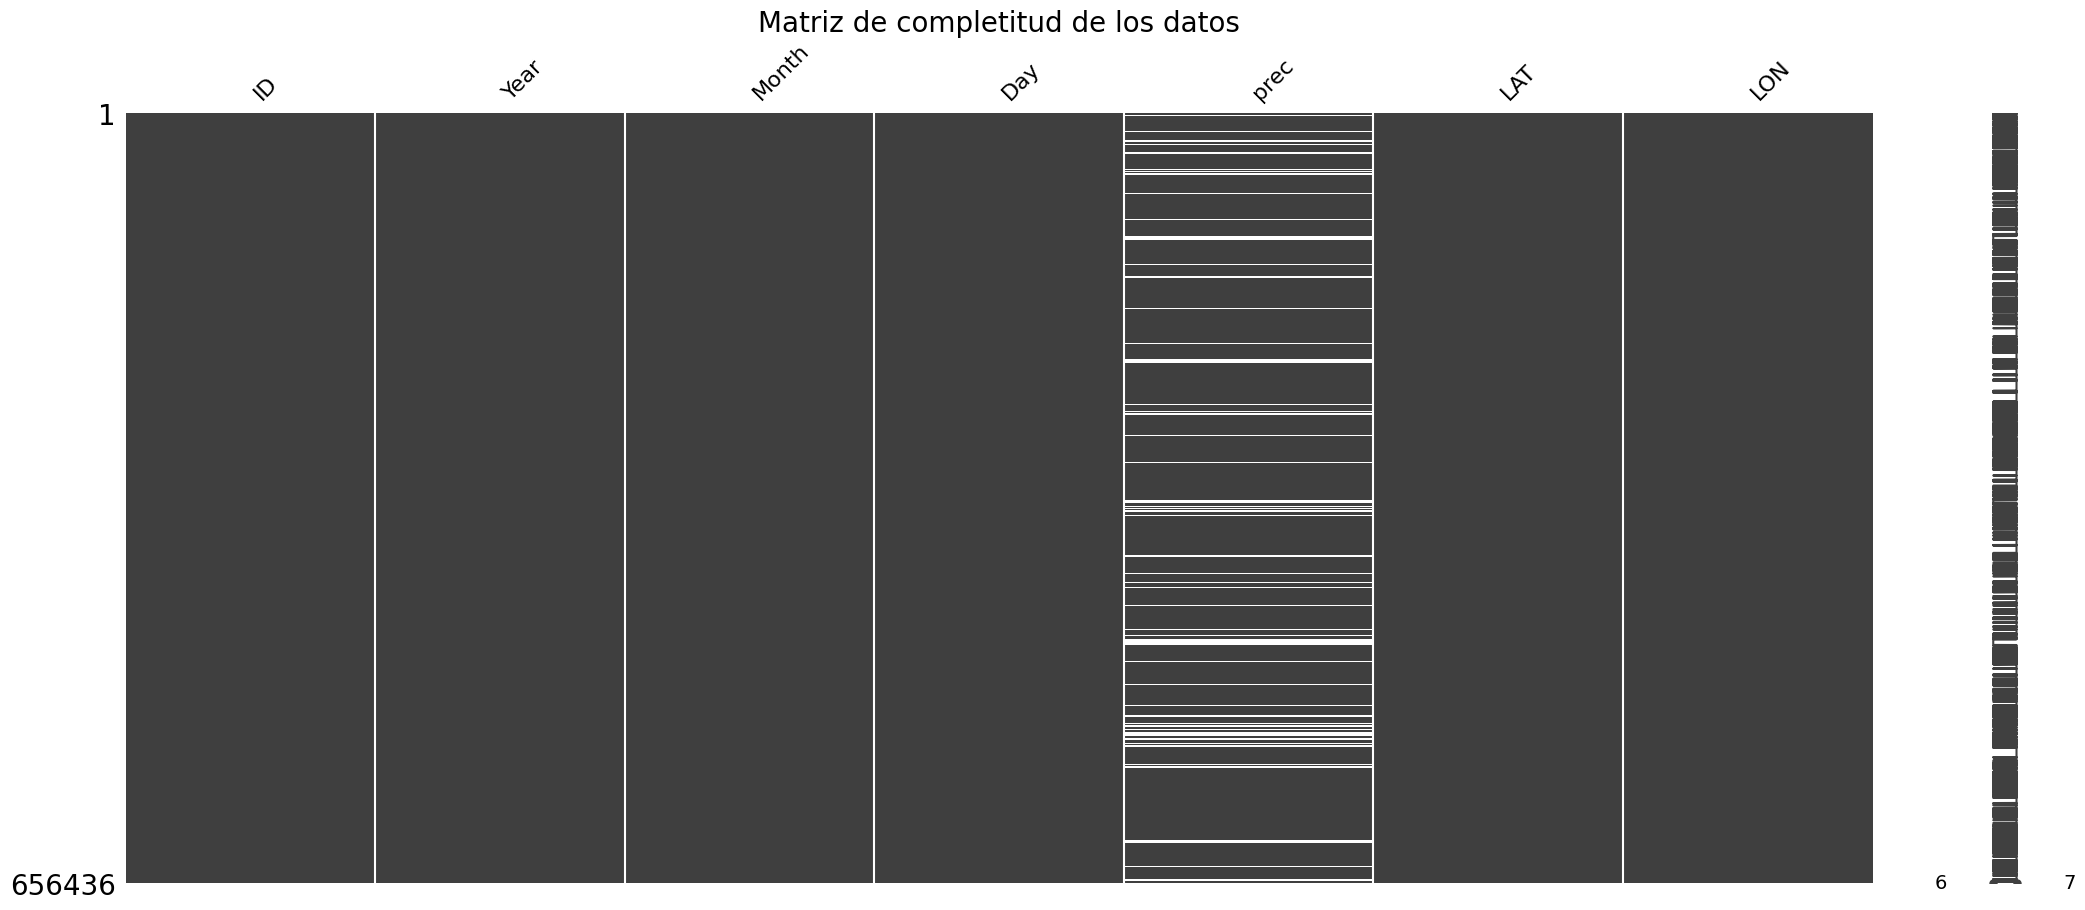

<Figure size 1000x600 with 0 Axes>

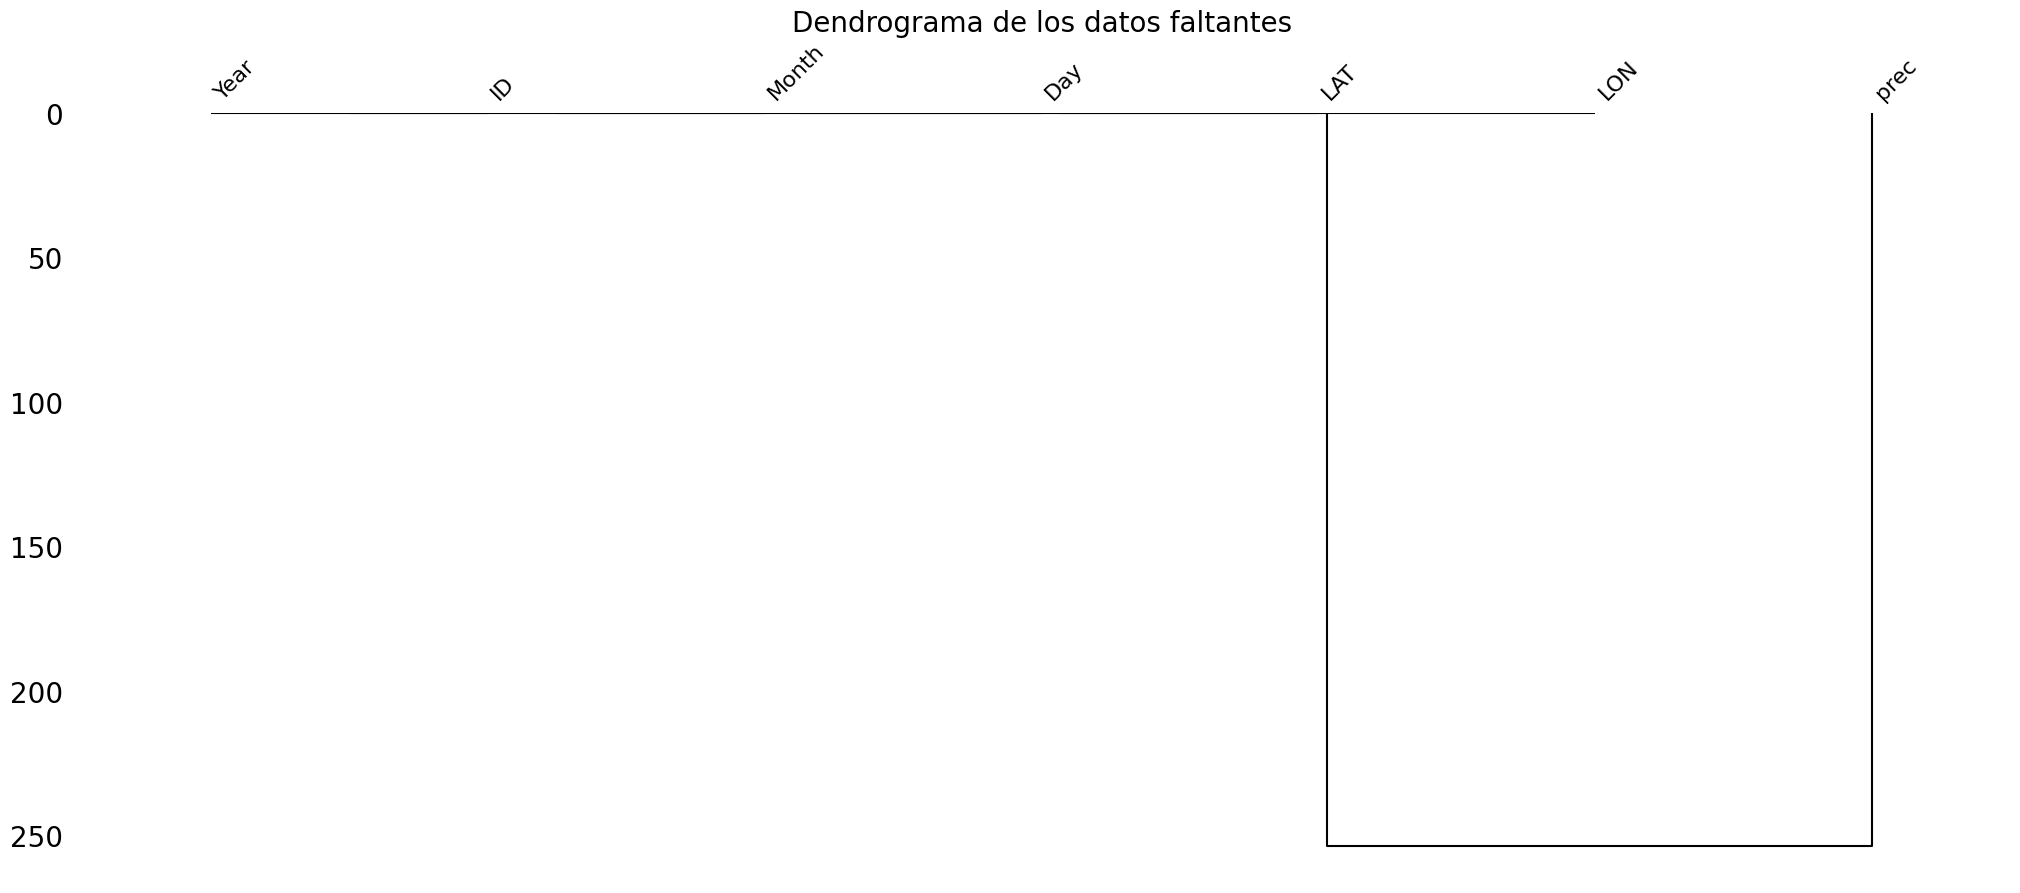

ID           0
Year         0
Month        0
Day          0
prec     64312
LAT          0
LON          0
dtype: int64


In [13]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

# Suponemos que 'data' es tu DataFrame

# Visualizar la completitud de los datos con matriz
plt.figure(figsize=(10,6))
msno.matrix(data)
plt.title('Matriz de completitud de los datos', fontsize=20)
plt.show()

# Agrupar las columnas con datos faltantes similares con dendrograma
plt.figure(figsize=(10,6))
msno.dendrogram(data)
plt.title('Dendrograma de los datos faltantes', fontsize=20)
plt.show()

# Resumen de la cantidad de datos faltantes por columna
print(data.isnull().sum())


## Porcentaje de missing values para la precipitación

In [14]:
import pandas as pd

# Agrupar por la columna 'ID' (identificación de la estación)
grouped_data = data.groupby('ID')

# Calcular el porcentaje de valores faltantes en precipitación por estación
missing_precipitation_percentage = grouped_data['prec'].apply(lambda x: (x.isna().sum() / len(x)) * 100)

# Crear un nuevo DataFrame con ID, LAT, LON y el porcentaje de valores faltantes en precipitación
result_df = data.groupby('ID').agg({'LAT': 'first', 'LON': 'first'})
result_df['Missing_Precipitation_Percentage'] = missing_precipitation_percentage

# Ordenar la tabla por el porcentaje de valores faltantes en precipitación de mayor a menor
result_df = result_df.sort_values(by='Missing_Precipitation_Percentage', ascending=False)

# Mostrar el nuevo DataFrame
result_df


,LAT,LON,Missing_Precipitation_Percentage
ID,,,
35035010,4.077111,-73.559917,46.517451
35010230,3.984639,-72.971222,44.462837
35185010,4.260361,-72.564472,36.246154
32120010,3.734083,-72.369778,34.925172
32060090,3.576222,-74.059639,31.858780
35030370,4.137389,-73.625000,28.718226
35010150,3.883333,-73.340000,28.170546
35035070,4.076722,-73.582000,23.521008
32075030,3.120389,-73.754028,20.390098


In [15]:
# Contar el número de estaciones únicas basadas en la columna 'ID'
num_unique_stations = data['ID'].nunique()

# Mostrar el número de estaciones únicas
print("Número de estaciones únicas:", num_unique_stations)


Número de estaciones únicas: 57


## Estaciones con porcentaje de missing values mayor o igual 10%

In [16]:
# Filtrar las estaciones con un porcentaje de valores faltantes en precipitación mayor o igual al 10%
filtered_stations = result_df[result_df['Missing_Precipitation_Percentage'] >= 10]

# Mostrar las estaciones filtradas
filtered_stations


,LAT,LON,Missing_Precipitation_Percentage
ID,,,
35035010,4.077111,-73.559917,46.517451
35010230,3.984639,-72.971222,44.462837
35185010,4.260361,-72.564472,36.246154
32120010,3.734083,-72.369778,34.925172
32060090,3.576222,-74.059639,31.858780
35030370,4.137389,-73.625000,28.718226
35010150,3.883333,-73.340000,28.170546
35035070,4.076722,-73.582000,23.521008
32075030,3.120389,-73.754028,20.390098


In [17]:
# Contar el número de estaciones únicas basadas en la columna 'ID'
num_unique_stations = filtered_stations['Missing_Precipitation_Percentage'].nunique()

# Mostrar el número de estaciones únicas
print("Número de estaciones únicas:", num_unique_stations)


Número de estaciones únicas: 18


Se realiza un filtro de las estaciones de monitoreo con un porcentaje de datos faltantes para la precipitación mayor o igual al 10%, ya que esto es un porcentaje significativo de datos faltantes, reduciendo el numero de estaciones a 18, y así enfocarnos en la muestra de resultados a estas estaciones, considerando que es más probable que se requieran acciones correctivas o una mayor atención.

In [18]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from joblib import parallel_backend

# Divide tus datos en un conjunto de entrenamiento y un conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['prec']), data['prec'], test_size=0.3, random_state=42)
# elimina nas de y_train
X_train = X_train[~y_train.isna()]
y_train = y_train.dropna()

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [25, 50, 100],
    'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3]
    # Otros hiperparámetros a optimizar
}

# Crear el modelo XGBoost
xgb_model = xgb.XGBRegressor()



In [19]:
##grid_search no es necesario volver a correr
# # Realizar la búsqueda de hiperparámetros utilizando validación cruzada
# with parallel_backend('loky', n_jobs=4):  # Ajusta n_jobs según el número de núcleos disponibles
#     grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
#     grid_search.fit(X_train, y_train)

In [20]:
## no es necesario volver a correr
# import joblib
# import pickle
# # Obtener los mejores hiperparámetros
# best_params = grid_search.best_params_
# print("Mejores hiperparámetros:", best_params)

# # Entrenar el modelo XGBoost con los mejores hiperparámetros
# best_xgb_model = xgb.XGBRegressor(**best_params)

# ##guardar modelo 
# joblib.dump(best_xgb_model, 'model_xgboost.pkl' )
# best_xgb_model.fit(X_train, y_train)

# # Evaluar el rendimiento del modelo en el conjunto de prueba
# y_pred = best_xgb_model.predict(X_test)

In [1]:
import os

file_path = 'model_xgboost.pkl'
if os.path.exists(file_path):
    print(f'El archivo {file_path} existe.')
else:
    print(f'El archivo {file_path} no se ha creado correctamente.')


El archivo model_xgboost.pkl no se ha creado correctamente.


In [2]:
## carga del modelo 
import joblib
import pickle
#modelo_xgboost = joblib.load('model_xgboost.pkl')
modelo_xgboost

NameError: name 'modelo_xgboost' is not defined

In [23]:
model_train=modelo_xgboost.fit(X_train, y_train)

# # Evaluar el rendimiento del modelo en el conjunto de prueba
# y_pred = modelo_xgboost.predict(X_test)

## Imputación de missing values para la precipitación

In [24]:

from joblib import Parallel, delayed
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
import pandas as pd

from joblib import Parallel, delayed

# Encontrar los índices donde la variable objetivo (y_test) tiene valores faltantes
missing_indices = y_test[y_test.isnull()].index

# Función para predecir valores faltantes usando el modelo XGBoost
def predict_missing_values(index, X_test, model_train):
    imputed_value = model_train.predict(X_test.loc[index].values.reshape(1, -1))
    return index, imputed_value[0]

# Paralelizar el proceso de predicción de valores faltantes
with parallel_backend('loky'):
    imputed_values = Parallel(n_jobs=-1)(
        delayed(predict_missing_values)(index, X_test, model_train) for index in missing_indices
    )

# Actualizar los valores faltantes en y_test con las predicciones
for index, value in imputed_values:
    y_test.loc[index] = value


In [25]:
imputed_values

[(2713, 5.0123487),
 (620480, 5.9809866),
 (528092, 11.83433),
 (529801, -1.2822449),
 (3912, 0.8204309),
 (126991, 8.44093),
 (598433, 2.2859838),
 (46864, -0.4578287),
 (254577, 8.010455),
 (541085, 19.230898),
 (109467, 20.014906),
 (265443, 5.921016),
 (583878, 8.6431),
 (457685, 14.059531),
 (452424, 12.627626),
 (626570, 0.28836656),
 (68876, 10.449091),
 (627940, 5.8375645),
 (60643, 8.303278),
 (519066, 12.068312),
 (317936, 7.535529),
 (317955, 2.489542),
 (460307, 10.193784),
 (449310, 9.02763),
 (451554, 0.4355603),
 (139163, 10.96573),
 (337349, -1.0489942),
 (195150, 9.592022),
 (569369, 0.9800679),
 (227490, 13.191251),
 (107541, 17.331783),
 (649255, 6.469077),
 (638838, 10.5673895),
 (127178, 0.78742003),
 (445884, 1.7610093),
 (530563, 4.3366237),
 (539226, 14.152651),
 (613680, 1.662444),
 (256210, 1.8690006),
 (525787, 14.288777),
 (247955, 9.5904665),
 (259840, 12.324784),
 (33410, 5.318111),
 (2684, 4.842811),
 (89322, 15.715226),
 (534171, 5.1459303),
 (106098, 21

In [26]:
missing_indices

Index([  2713, 620480, 528092, 529801,   3912, 126991, 598433,  46864, 254577,
       541085,
       ...
       620523, 558010, 486639, 620973,   2555, 450913, 325831, 519059, 530604,
       105196],
      dtype='int64', length=19303)

In [27]:
# Conteo de valores faltantes después de la imputación
missing_values_after_imputation = y_test.isnull().sum()
print("Cantidad de valores faltantes después de la imputación:", missing_values_after_imputation)


Cantidad de valores faltantes después de la imputación: 0


In [28]:
# Obtener algunos valores originales y valores imputados para comparar
original_values = data['prec'].loc[y_test.index]
imputed_values = y_test.copy()  # Hacer una copia de y_test para mantener los valores originales
imputed_values.loc[missing_indices] = imputed_values  # Asignar los valores imputados en los índices faltantes


# Comparación de valores originales e imputados (por ejemplo, mostrando los primeros 10)
comparison_df = pd.DataFrame({'Original': original_values, 'Imputed': imputed_values})
print(comparison_df)


        Original  Imputed
439729       0.0      0.0
422198       0.0      0.0
163861      28.0     28.0
362187       0.0      0.0
532441      63.7     63.7
...          ...      ...
610977       4.0      4.0
541545       2.7      2.7
441958      52.0     52.0
112451      46.0     46.0
553561       0.0      0.0

[196931 rows x 2 columns]


In [29]:
# Concatenar las columnas 'Precipitacion' de data y imputed_data en un nuevo DataFrame
merged_data = pd.concat([data, comparison_df[['Imputed','Original']]], axis=1)

# Verificar el nuevo DataFrame que contiene ambas columnas
print(merged_data)

              ID  Year  Month  Day  prec       LAT        LON  Imputed   
0       32010010  1983      6    9   6.8  2.562833 -74.103083      6.8  \
1       32010010  1983      6   10  17.8  2.562833 -74.103083      NaN   
2       32010010  1983      6   11   0.0  2.562833 -74.103083      0.0   
3       32010010  1983      6   12   0.5  2.562833 -74.103083      NaN   
4       32010010  1983      6   13   6.9  2.562833 -74.103083      NaN   
...          ...   ...    ...  ...   ...       ...        ...      ...   
656431  35185010  2014      7   14   0.1  4.260361 -72.564472      NaN   
656432  35185010  2014      7   15   9.8  4.260361 -72.564472      NaN   
656433  35185010  2014      7   16   0.0  4.260361 -72.564472      NaN   
656434  35185010  2014      7   17   4.5  4.260361 -72.564472      4.5   
656435  35185010  2014      7   18   0.0  4.260361 -72.564472      0.0   

        Original  
0            6.8  
1            NaN  
2            0.0  
3            NaN  
4            NaN

In [30]:
merged_data['prec']

0          6.8
1         17.8
2          0.0
3          0.5
4          6.9
          ... 
656431     0.1
656432     9.8
656433     0.0
656434     4.5
656435     0.0
Name: prec, Length: 656436, dtype: float64

## Métricas 

In [31]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Suponiendo que tienes un DataFrame llamado 'data' con las estaciones identificadas por 'ID'
# y las columnas 'original_values' e 'imputed_values'

# Función para calcular RMSE y R² por estación
def calculate_metrics(group):
    original_values = merged_data['Original']
    imputed_values = merged_data['Imputed']

    # Filtrar valores NaN de las series de datos
    valid_indices = ~np.isnan(original_values) & ~np.isnan(imputed_values)
    original_values_no_nan = original_values[valid_indices]
    imputed_values_no_nan = imputed_values[valid_indices]

    # Calcular métricas de evaluación
    mse = mean_squared_error(original_values_no_nan, imputed_values_no_nan)
    r2 = r2_score(original_values_no_nan, imputed_values_no_nan)
    mae = mean_absolute_error(original_values_no_nan, imputed_values_no_nan)


    return pd.Series({'RMSE': np.sqrt(mse), 'R²': r2,'MAE': mae})

# Agrupar por estación y calcular métricas por estación
metrics_by_station = merged_data.groupby('ID').apply(calculate_metrics)
print(metrics_by_station)


          RMSE   R²  MAE
ID                      
32010010   0.0  1.0  0.0
32020020   0.0  1.0  0.0
32030020   0.0  1.0  0.0
32035010   0.0  1.0  0.0
32035020   0.0  1.0  0.0
32060020   0.0  1.0  0.0
32060030   0.0  1.0  0.0
32060060   0.0  1.0  0.0
32060090   0.0  1.0  0.0
32060100   0.0  1.0  0.0
32065010   0.0  1.0  0.0
32070010   0.0  1.0  0.0
32070020   0.0  1.0  0.0
32070030   0.0  1.0  0.0
32070040   0.0  1.0  0.0
32070060   0.0  1.0  0.0
32070080   0.0  1.0  0.0
32070090   0.0  1.0  0.0
32070100   0.0  1.0  0.0
32070110   0.0  1.0  0.0
32070120   0.0  1.0  0.0
32075030   0.0  1.0  0.0
32075040   0.0  1.0  0.0
32075050   0.0  1.0  0.0
32075060   0.0  1.0  0.0
32075080   0.0  1.0  0.0
32080010   0.0  1.0  0.0
32090010   0.0  1.0  0.0
32120010   0.0  1.0  0.0
33035010   0.0  1.0  0.0
35010010   0.0  1.0  0.0
35010020   0.0  1.0  0.0
35010040   0.0  1.0  0.0
35010060   0.0  1.0  0.0
35010070   0.0  1.0  0.0
35010080   0.0  1.0  0.0
35010090   0.0  1.0  0.0
35010150   0.0  1.0  0.0


### XGBOOST(imputacion ejemplo)

In [33]:
##ejemplo de imputacion con boosting
import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Crear datos de ejemplo con valores faltantes
np.random.seed(42)
n_samples = 1000
X = np.random.rand(n_samples, 4)
y = np.random.rand(n_samples, 1)
mask = np.random.rand(n_samples, 4) < 0.5
X[mask] = np.nan

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear un conjunto de datos de LightGBM para el entrenamiento
train_data = lgb.Dataset(X_train, label=y_train)

# Definir el objetivo del modelo y las características de las variables
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'num_leaves': 31,
    'learning_rate': 0.05,
}

# Entrenar el modelo
model = lgb.train(params, train_data, num_boost_round=2000)

# Predecir los valores faltantes en el conjunto de prueba
preds = model.predict(X_test)

# Calcular el error cuadrático medio (RMSE) entre los valores reales y las predicciones
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)
print("RMSE: ", rmse)
print("R2: ", r2)
    

c:\Users\vhect\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:300: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


RMSE:  0.352435001196264
R2:  -0.5017045093256591


In [34]:
y_test.shape


(200, 1)

In [35]:
preds.shape

(200,)

## Bibliografia 

Little, R. J. A., & Rubin, D. B. (2002). Statistical Analysis with Missing Data (Vol. 333). John Wiley & Sons.